# Traffic Data Analysis Task

Given a simple excel spreadsheet, analyse this data and produce visualizations.

This task was designed to help learn plotting functions available in `Matplotlib` and `Seaborn`, two data visualisation libraries in Python. The task also helped learn some particular methods of analysing data via the `Pandas` library.

The spreadsheet contains a table with the following data about the passing vehicles:
- date
- time
- direction (S1 - Southbound, N0 - Northbound)
- speed
- category (light, medium, heavy) 

The speed limit for this location is 60 mph.

### Vehicle classification chart
![Vehicle Classification](classification.jpg)

### Loading the data

In [241]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()  # styles
SPEED_LIMIT = 60

# Load and prepare the dataframe from the data file
df = pd.read_excel('data.xlsx').loc[:, :'Class']
df['Datetime'] = df.apply(lambda x: datetime.combine(x['Date'], x['Time']), axis=1)
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.set_index('Datetime', inplace=True)  # set a DatetimeIndex
df['Class'].replace('Light0', 'Light', inplace=True)  # clean up error in the source data

df.head()

,Direction,Speed,Class
Datetime,,,
2020-12-03 00:01:21,S1,44.19,Light
2020-12-03 00:01:32,S1,52.50,Light
2020-12-03 00:17:16,N0,29.93,Light
2020-12-03 00:57:46,N0,32.10,Light
2020-12-03 01:14:44,S1,23.91,Medium


In [242]:
# get the highest hourly means - typically late night where there's few cars on the road
# one car speeding at this time can greatly influence the overall mean, since there's so few cars.
df['Speed'].resample('H').mean().dropna().sort_values()[::-1]

Datetime
2020-12-09 00:00:00    63.267273
2020-12-05 04:00:00    63.050000
2020-12-05 02:00:00    61.650000
2020-12-06 23:00:00    61.381429
2020-12-04 01:00:00    60.875000
                         ...    
2020-12-07 01:00:00    31.880000
2020-12-03 01:00:00    31.646667
2020-12-04 07:00:00    27.565926
2020-12-03 02:00:00    27.030000
2020-12-03 03:00:00    24.273333
Name: Speed, Length: 166, dtype: float64

### Analysis

In [243]:
# mean for each direction
# we can see that the speed is higher overall in the southbound direction
df.groupby('Direction').mean()

,Speed
Direction,
N0,50.980979
S1,52.453993


In [244]:
# global summary stats
print(f"Mean: {df['Speed'].mean()}")
print(f"Maximum: {df['Speed'].max()}")
print(f"Minimum: {df['Speed'].min()}")
print(f"Standard Deviation: {df['Speed'].std()}")

Mean: 51.703404562981795
Maximum: 111.76
Minimum: 11.02
Standard Deviation: 9.80828416203117


In [245]:
# class-based summary stats
classes = ['Light', 'Medium', 'Heavy']

for _class in classes:
    df_filtered = df[df['Class'] == _class]
    print("Class: ", _class)
    print(f"Mean: {df_filtered['Speed'].mean()}")
    print(f"Maximum: {df_filtered['Speed'].max()}")
    print(f"Minimum: {df_filtered['Speed'].min()}")
    print(f"Standard Deviation: {df_filtered['Speed'].std()}")
    print("--------------")

Class:  Light
Mean: 51.90760460061586
Maximum: 111.76
Minimum: 11.02
Standard Deviation: 9.868009402056211
--------------
Class:  Medium
Mean: 50.16061908230157
Maximum: 79.88
Minimum: 15.9
Standard Deviation: 9.21081430312553
--------------
Class:  Heavy
Mean: 47.566060606060596
Maximum: 61.75
Minimum: 31.07
Standard Deviation: 7.055609886552128
--------------


In [246]:
# % of cars violating speed
pct = np.sum(df['Speed'] > 60) / len(df) * 100
print(f"{pct:.2f}% of cars are violating the 60mph speed limit")

17.05% of cars are violating the 60mph speed limit


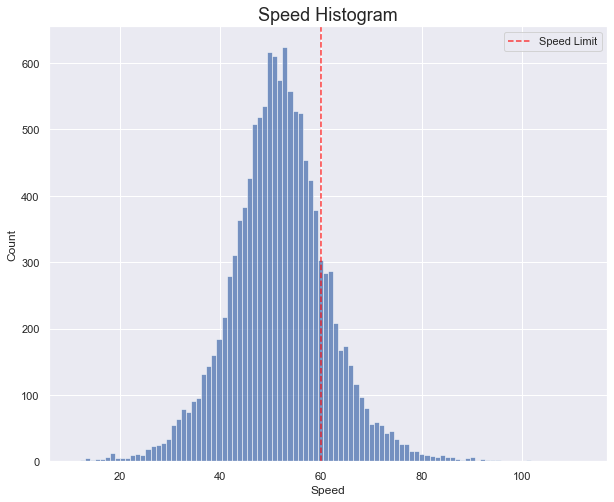

In [247]:
# Histogram of speeds
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x='Speed', stat='count', bins=100, ax=ax)
plt.axvline(x=60,ymin=0, ymax=1, color='red', alpha=.75, linestyle='--', label='Speed Limit')
plt.title("Speed Histogram", fontsize=18)
plt.legend()
plt.show()

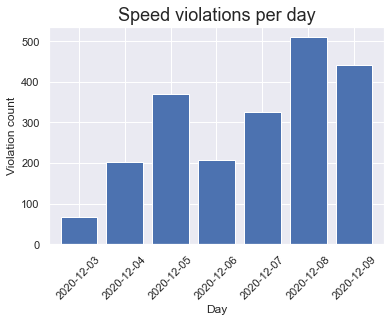

In [248]:
# traffic violations per day.
violations = df[df['Speed'] > SPEED_LIMIT]
violations_per_day = violations['Speed'].groupby(violations.index.date).count()
violations_per_day.plot(kind='bar', width=.8)
plt.title('Speed violations per day', fontsize=18)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Violation count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

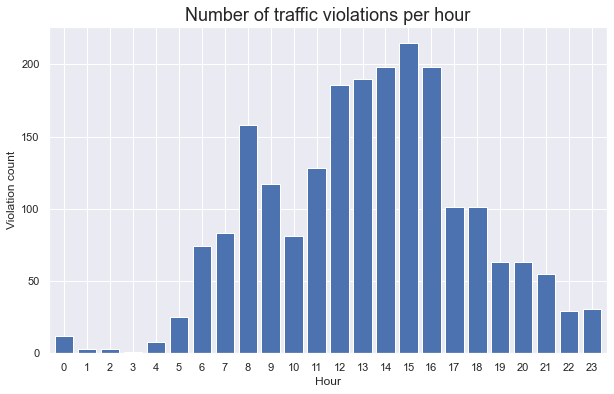

In [249]:
# number of traffic violations per hour
violations_per_hour = violations['Speed'].groupby(violations.index.hour).count()
violations_per_hour.plot(kind='bar', width=.8, figsize=(10,6))
plt.title('Number of traffic violations per hour', fontsize=18)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Violation count', fontsize=12)
plt.xticks(rotation=0)
plt.show()

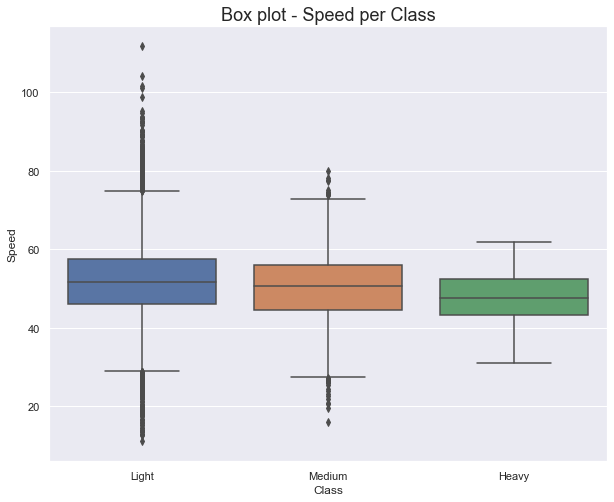

In [250]:
# box plot: speeds per class
# We can see much more variety in the light vehicle speeds (i.e. higher standard deviation)
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='Class', y='Speed')
plt.title("Box plot - Speed per Class", fontsize=18)
plt.show()

Text(0, 0.5, 'Violation count')

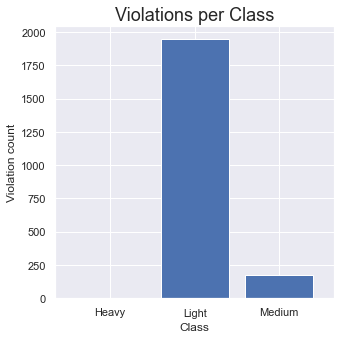

In [251]:
violations.groupby('Class')['Speed'].count().plot(kind='bar', width=.8, figsize=(5,5))
plt.xticks(rotation=0)
plt.title("Violations per Class", fontsize=18)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Violation count', fontsize=12)

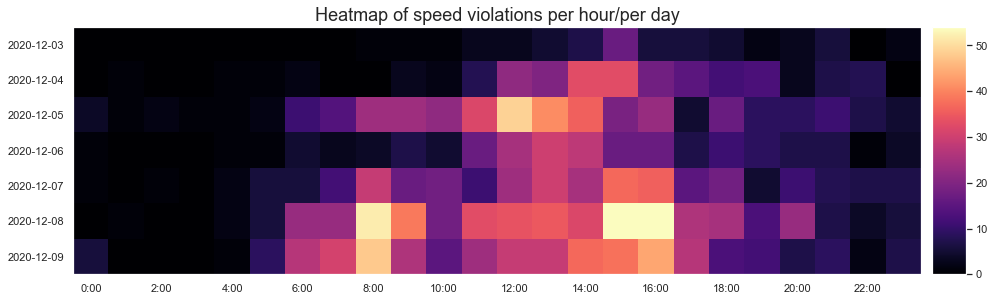

In [252]:
## heatmap
# Shows when violations occurred as a 2D grid over date and hour
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

hours = np.arange(24)
dates = np.unique(df.index.date)
arr = np.zeros((len(dates), len(hours)))  # container array that will be filled with the number of traffic violations

for i, date in enumerate(dates):
    violations_on_day = violations[violations.index.date == date]['Speed']
    violations_per_hour = violations_on_day.groupby(violations_on_day.index.hour).count()
    
    for hour in hours:
        try:
            arr[i][hour] = violations_per_hour[hour]
        except KeyError:
            arr[i][hour] = 0

fig, ax = plt.subplots(figsize=(16,8))
img = ax.imshow(arr, 'magma')
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels([f"{x}:00" for x in np.arange(0,24,2)])
ax.set_yticks(np.arange(len(dates)))
ax.set_yticklabels(dates)
ax.fmt_ydata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Heatmap of speed violations per hour/per day', fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.16)
fig.colorbar(img, cax=cax)
ax.grid(False)
plt.show()

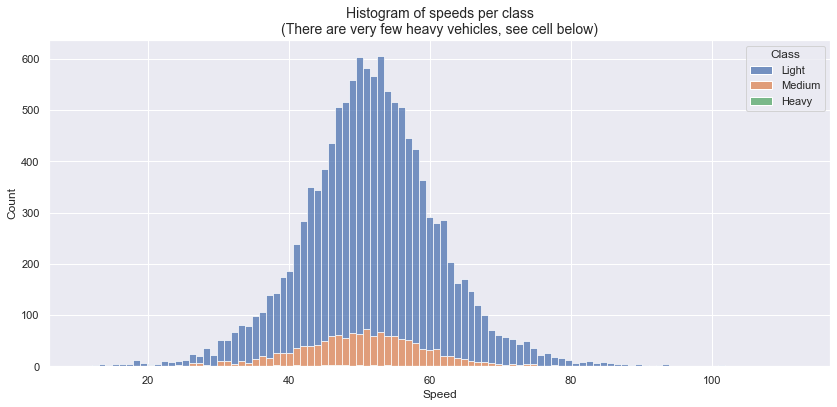

In [253]:
fig, ax = plt.subplots(figsize=(14,6))
ax = sns.histplot(df, hue='Class', x='Speed', multiple='stack', ax=ax)
ax.set_title("Histogram of speeds per class\n(There are very few heavy vehicles, see cell below)", fontsize=14)
plt.show()

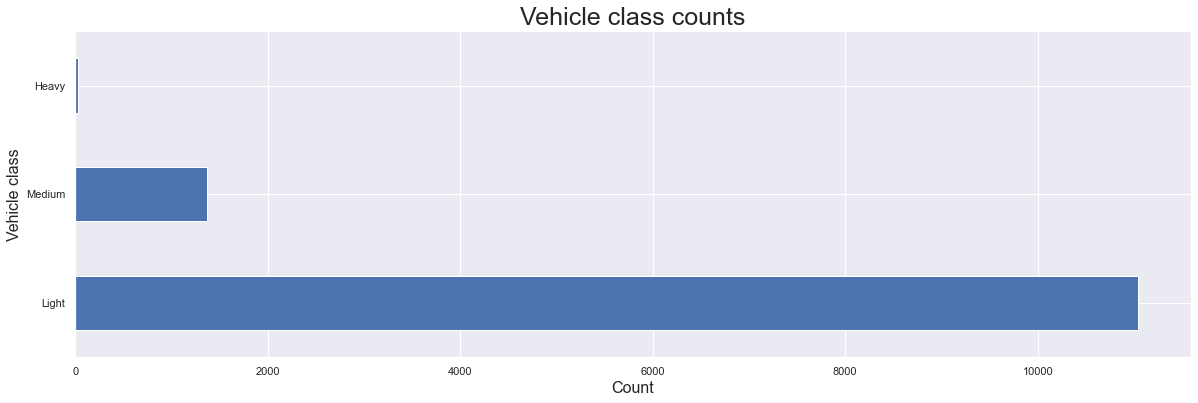

In [254]:
fig,ax = plt.subplots(figsize=(20,6))
df['Class'].value_counts().plot(kind='barh')
ax.set_title("Vehicle class counts", fontsize=25)
ax.set_xlabel("Count", fontsize=16)
ax.set_ylabel("Vehicle class", fontsize=16)
plt.show()

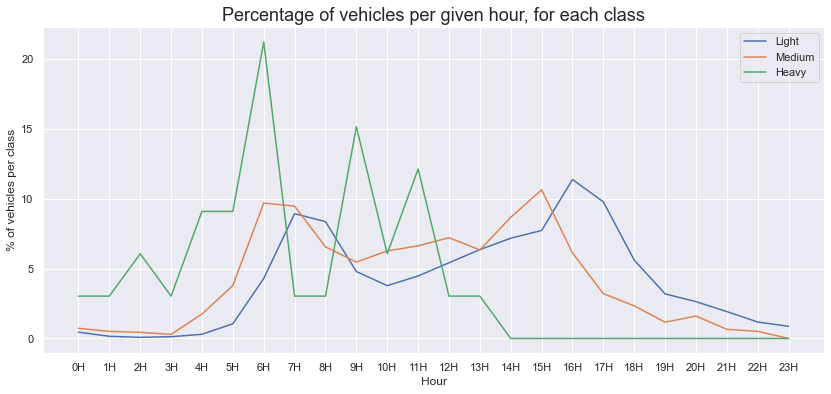

In [255]:
classes = ['Light', 'Medium', 'Heavy'] 

fig, ax = plt.subplots(1,1, figsize=(14,6))
hours = np.arange(24)

for idx, _class in enumerate(classes):
    df_by_class = df[df['Class'] == _class]
    total_records = len(df_by_class)
    counts_per_hour = df_by_class.groupby(df_by_class.index.hour).count()['Class']
    counts_pct = counts_per_hour / total_records * 100
    for i in range(24):
        try:
            counts_pct.iloc[i]
        except IndexError as e:
            counts_pct = counts_pct.append(pd.Series({i: 0.0}))
    plt.plot(np.arange(24), counts_pct, label=_class)
    

plt.title("Percentage of vehicles per given hour, for each class", fontsize=18)
plt.legend()
plt.xticks(np.arange(24), labels=[f"{i}H" for i in np.arange(24)])
plt.xlabel("Hour")
plt.ylabel("% of vehicles per class")
plt.show()